In [83]:
import pandas as pd
import tensorflow as tf
import numpy as np
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

In [2]:
df = pd.read_csv("wrong_prediction.csv")

def remove(s:str) -> None:
    return s[16::]


class_labels = json.load(open('CWOX-1-main/CWOX/imagenet_class_index.json', 'r'))

# folder : nums_label
folder_to_nums = {class_labels[key][0]: key for key in class_labels.keys()}

In [106]:
model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet')

model.compile(loss='categorical_crossentropy', metrics=['acc'])

grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer("mixed10").output, model.output]
)

#######Process############
def process(x):
    # i = tf.keras.layers.Input(x, dtype = tf.uint8)
    x = tf.cast(x, tf.float32)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    return x

def make_gradcam_heatmap(img_array, grad_model, pred_index):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # if pred_index is None:
        #     pred_index = tf.argmax(preds[0])

        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, cam_path):

    # plt.figure(figsize=[12,8],dpi=200)
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path,target_size=(299,299))
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    jet_heatmap = jet_heatmap / 255
    
    threshold = np.max(jet_heatmap) * 0.3
    
    tmp = np.copy(img)
    
    img[jet_heatmap[:,:,0] < threshold] = 0
    tmp[jet_heatmap[:,:,0] >= threshold] = 0
    
    return img,tmp
    # Superimpose the heatmap on original image
    # superimposed_img_array = img + jet_heatmap * 0.3

    # superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img_array)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))

    # return superimposed_img_array

def transform_gradcam(img_path,processed_img_array, grad_model, pred_index,cam_path):
    
    heatmap = make_gradcam_heatmap(processed_img_array, grad_model,pred_index)

    return save_and_display_gradcam(img_path, heatmap,cam_path)

#### Example


Text(0.5, 1.0, 'Opposite Purified Example')

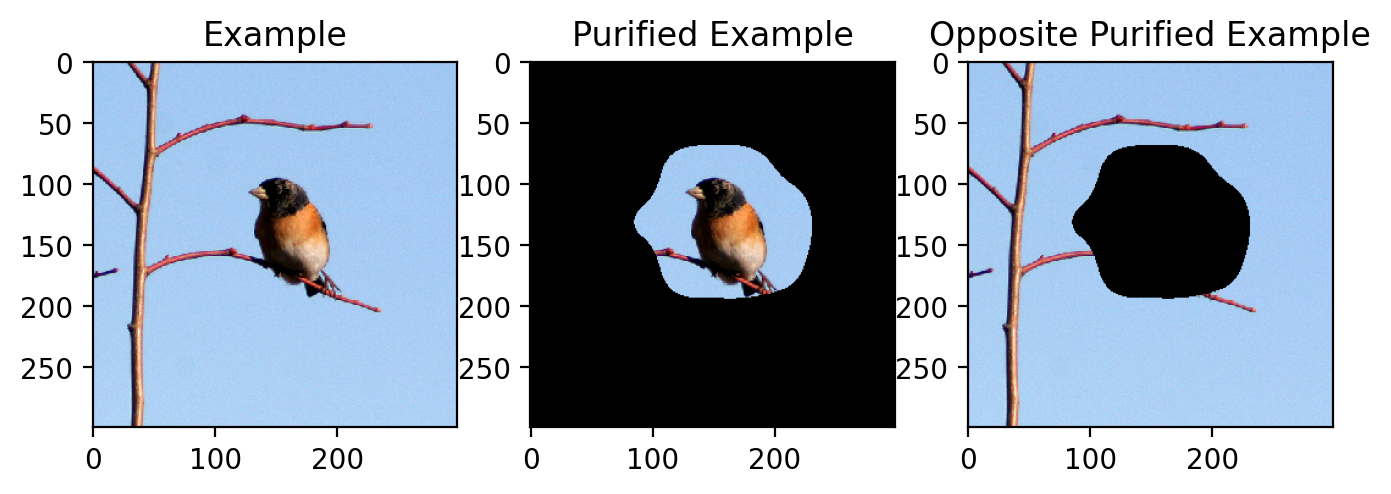

In [175]:
true_img_path =  "val/n01530575/ILSVRC2012_val_00045172.JPEG"

true_image = tf.keras.preprocessing.image.load_img(true_img_path, target_size=(299,299))
            
true_img_array = tf.keras.preprocessing.image.img_to_array(true_image)
    
label = int(folder_to_nums["n01530575"])

x = process(true_img_array)
y = model.predict(x)
pred = np.argmax(y)

purified_img_array,op_purified_img_array = transform_gradcam(true_img_path,x,grad_model,pred,None)

purified_img,op_purified_img = tf.keras.preprocessing.image.array_to_img(purified_img_array),tf.keras.preprocessing.image.array_to_img(op_purified_img_array)

plt.figure(figsize = [8,3], dpi = 200)
plt.subplot(1,3,1)
plt.imshow(true_image)
plt.title("Example")
plt.subplot(1,3,2)
plt.imshow(purified_img)
plt.title("Purified Example")
plt.subplot(1,3,3)
plt.imshow(op_purified_img)
plt.title("Opposite Purified Example")

In [108]:
last_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer("avg_pool").output]
)

h = last_model(x).numpy().T
h_prime = last_model(process(purified_img_array)).numpy().T # (2048,1)
h_prime_op = last_model(process(op_purified_img_array)).numpy().T
w = model._layers[-1].weights[0].numpy() # (2048,1000)

In [109]:
contribution = np.multiply(h_prime,w)
op_contribution = np.multiply(h_prime_op,w)

Text(0.5, 1.0, 'Subtraction')

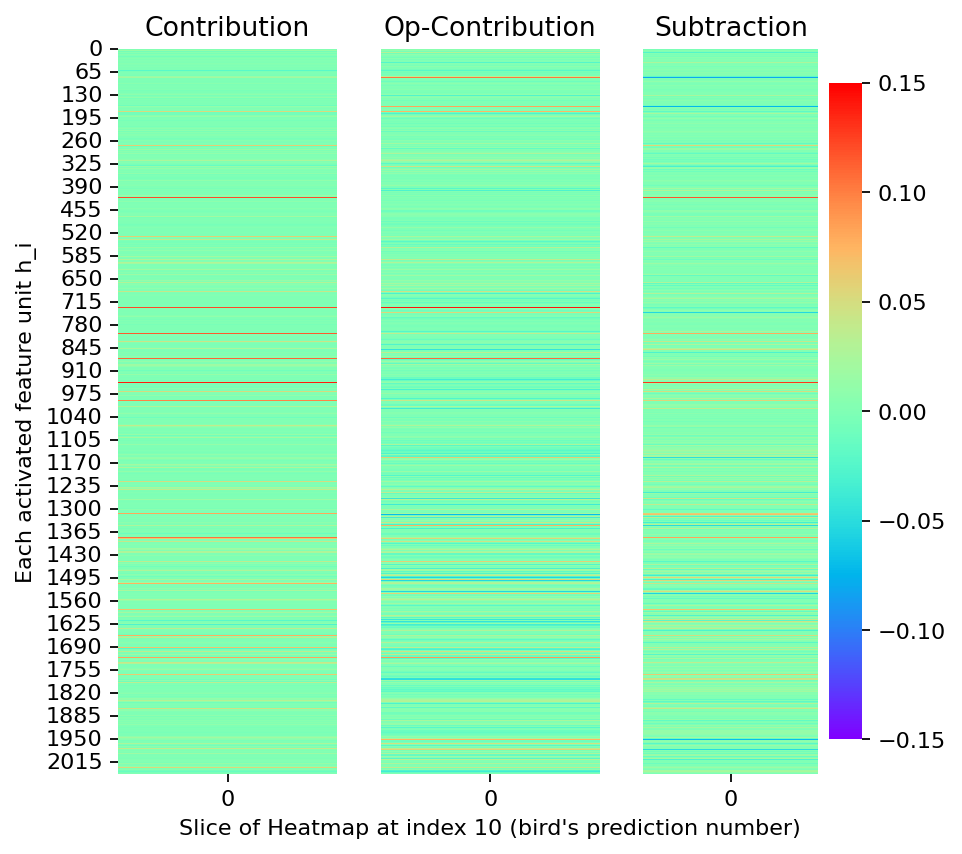

In [139]:
plt.figure(figsize = [6,6], dpi = 160)
plt.subplot(1,3,1)
sns.heatmap(contribution[:,10].reshape(2048,1),cmap = 'rainbow',cbar = False,vmin = -0.15,vmax = 0.15)
plt.ylabel("Each activated feature unit h_i")
plt.title("Contribution")
plt.subplot(1,3,2)
sns.heatmap(op_contribution[:,10].reshape(2048,1),cmap = 'rainbow',yticklabels = False,cbar = False,vmin = -0.15,vmax = 0.15)
plt.xlabel("Slice of Heatmap at index 10 (bird's prediction number)")
plt.title("Op-Contribution")
plt.subplot(1,3,3)
sns.heatmap((contribution[:,10] - op_contribution[:,10]).reshape(2048,1),cmap = 'rainbow',yticklabels = False,vmin = -0.15,vmax = 0.15)
plt.title("Subtraction")

### Import Feature Unit
    - True Important : High contribution and Low op-contribution
        Corresponds to GroundTruth object
    - Fake Important: Both contribution & op-contribution is high 
        Correspnds to background (likes trees behind birds)
    - Unimportant: Low contribution

In [250]:
contrib = np.load("contribution.npy")

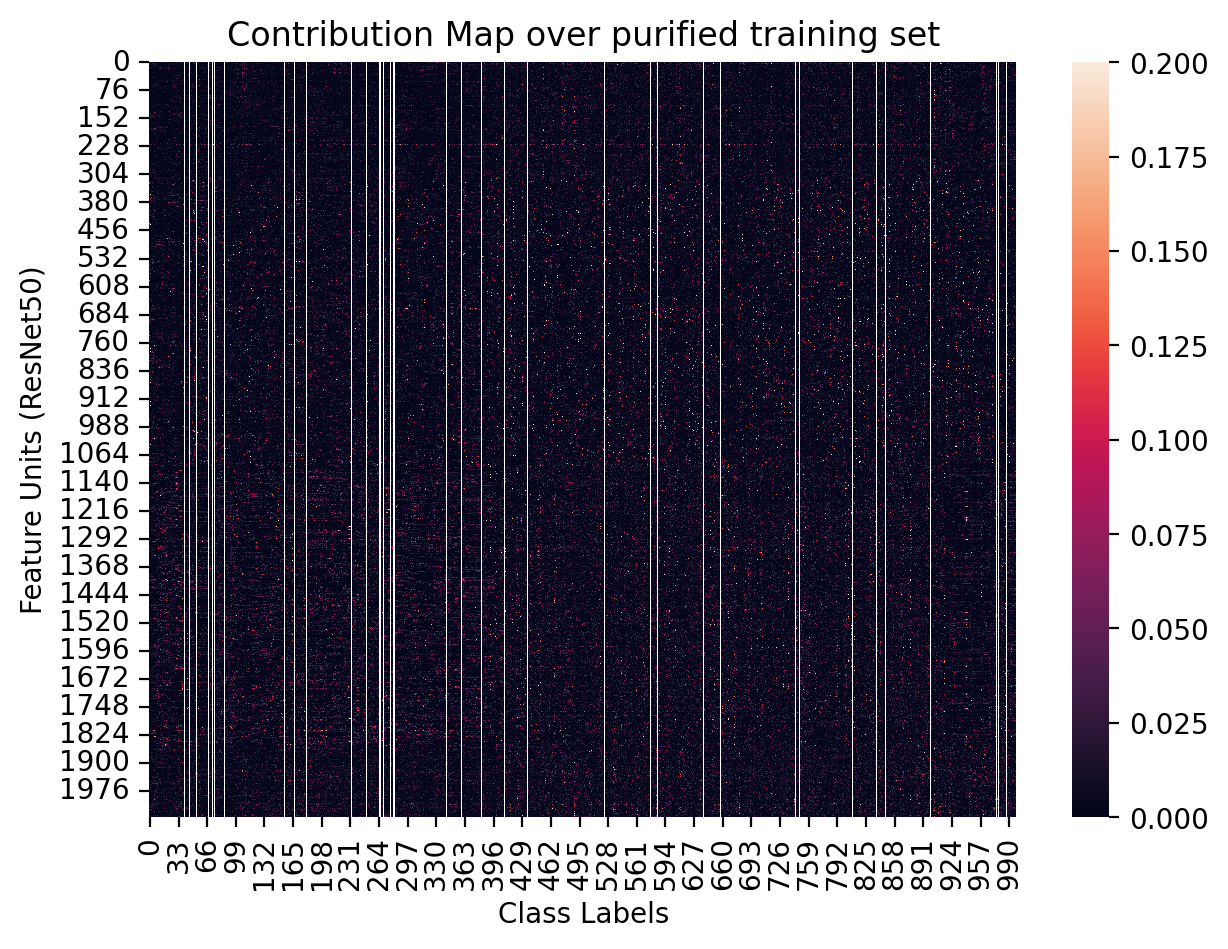

In [254]:
plt.figure(figsize = [7,5], dpi = 200)
sns.heatmap(contrib,vmax = 0.2,vmin = 0.0)
plt.xlabel('Class Labels')
plt.ylabel("Feature Units (ResNet50)")
plt.title("Contribution Map over purified training set")
plt.savefig("contribution.png",dpi = 200)

In [244]:
contrib_car = np.load("/Users/shawin/Desktop/contribution_car.npy")

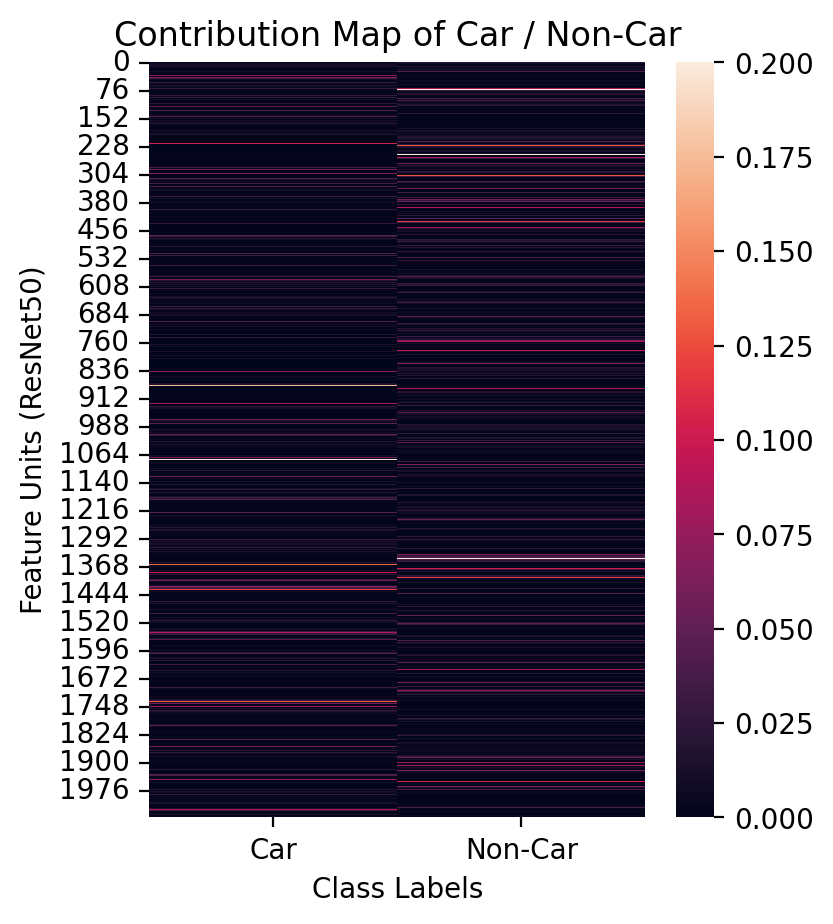

In [267]:
plt.figure(figsize = [4,5], dpi = 200)
sns.heatmap(contrib_car,vmin = 0, vmax = 0.2, xticklabels=['Car','Non-Car'])
plt.xlabel('Class Labels')
plt.ylabel("Feature Units (ResNet50)")
plt.title("Contribution Map of Car / Non-Car")
plt.savefig("contribution.png",dpi = 200)